In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K
from IPython.display import display

<b>Dataset preprocessing</b>

In [2]:
path = './data/asl_alphabet/'
model_dir = path + 'asl_model.h5'
load = True

train = tf.keras.utils.image_dataset_from_directory(
    path + 'train',
    image_size=(200, 200),
    validation_split=0.2,
    subset='training',
    seed=1
)

validation = tf.keras.utils.image_dataset_from_directory(
    path + 'train',
    image_size=(200, 200),
    validation_split=0.2,
    subset='validation',
    seed=1
)

test = tf.keras.utils.image_dataset_from_directory(
    path + 'test',
    image_size=(200, 200)
)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Found 29 files belonging to 29 classes.


In [3]:
labels = train.class_names
print(labels)
print(len(labels))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
def normalize(feature, label):
    feature = normalization_layer(feature)
    label = tf.one_hot(tf.cast(label, tf.int32), 29)
    label = tf.cast(label, tf.float32)
    return feature, label

In [5]:
train = train.map(lambda x, y: normalize(x,y))
validation = validation.map(lambda x, y: normalize(x,y))

In [6]:
test = test.map(lambda x, y: (normalization_layer(x), y))
test = list(test.unbatch().as_numpy_iterator())
x_test = [x[0] for x in test]
y_test = [y[1] for y in test]
x_test = np.array(x_test)
y_test = np.array(y_test)

2022-06-02 17:54:39.948273: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


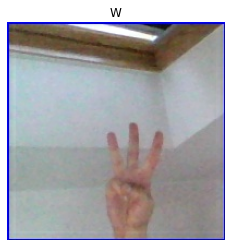

In [7]:
for x_batch, y_batch in train.take(1):
    plt.imshow(x_batch[0])
    label = np.argmax(y_batch[0].numpy())
    plt.title(labels[label])
    plt.axis('off')
    break

<b>Model</b>

In [8]:
if load:
    model = tf.keras.models.load_model(model_dir)
else:
    model = tf.keras.Sequential(
        layers = [
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 3)),
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),

            tf.keras.layers.GlobalAveragePooling2D(),

            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),

            tf.keras.layers.Dense(29, activation='softmax'),
        ]
    )

model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
)

In [9]:
if not load:
    history = model.fit(
        train,
        validation_data=validation,
        epochs=10
    )

    model.save(model_dir)

<b>Predictions</b>

In [10]:
preds = model.predict(x_test)
pred_classes = np.argmax(preds, axis = 1) 

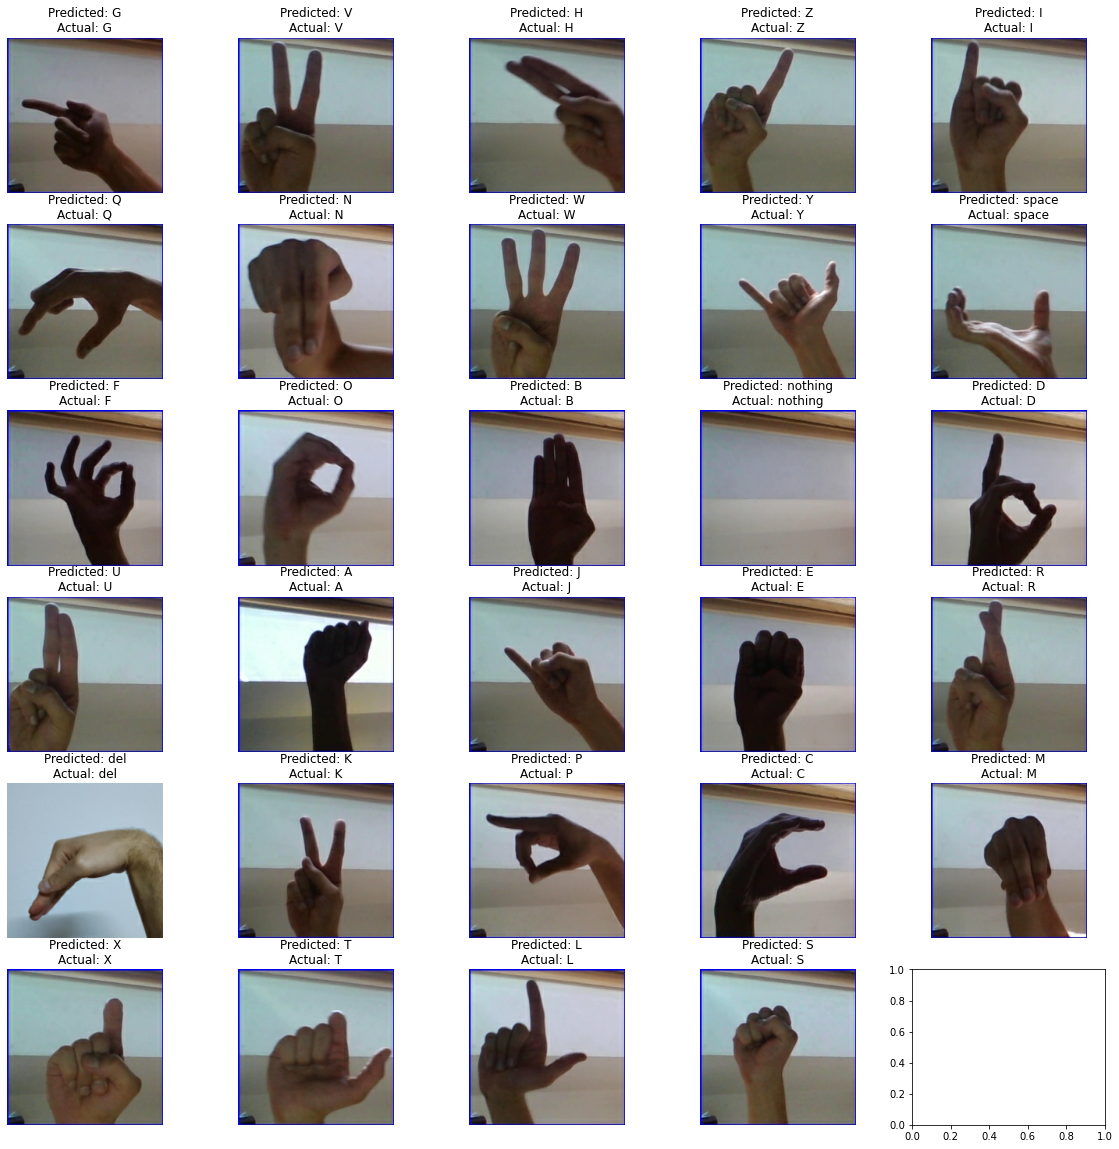

In [11]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))
axs = axs.flatten()

for i, prediction in enumerate(pred_classes):
    predicted = labels[prediction]
    actual = labels[y_test[i]]
    axs[i].imshow(x_test[i])
    axs[i].set(title=f'Predicted: {predicted}\nActual: {actual}')
    axs[i].axis('off')